# EMOTION DETECTION

# IMPORTING REQUIRED LIBRARIES

In [4]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


# EXPLORING DATASET

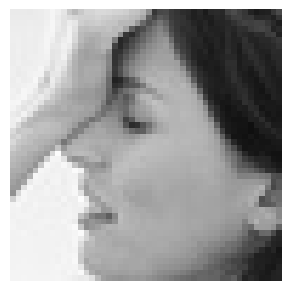

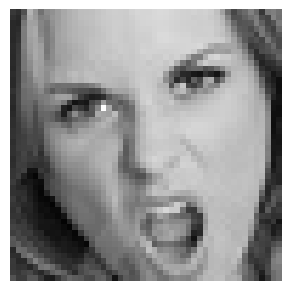

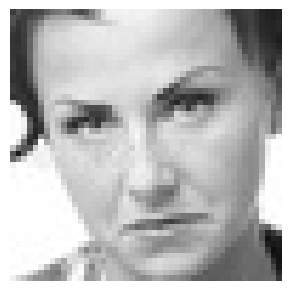

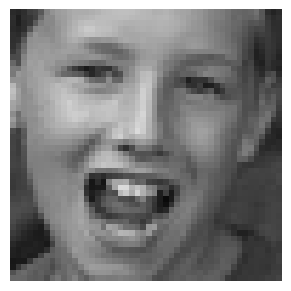

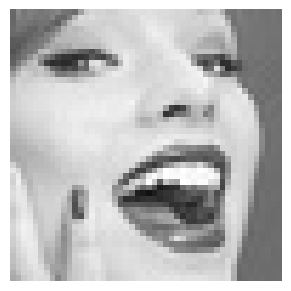

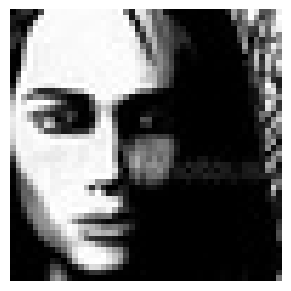

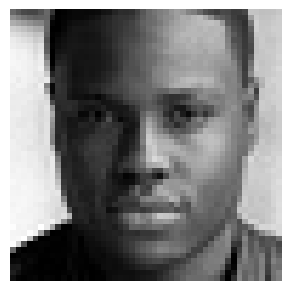

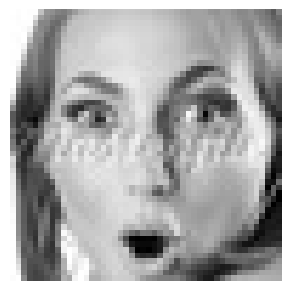

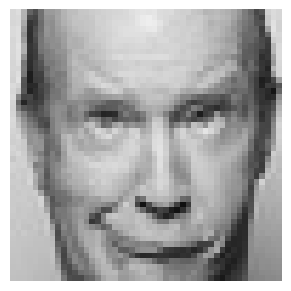

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)); plt.axis('off')
    

# PREPARING DATA FOR TRAINING

In [10]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_gen = datagen_train.flow_from_directory("TRAIN/",
                                             target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("TEST/",
                                             target_size = (img_size, img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# DEFINING MODEL

In [5]:
def Convolution(input_tensor,filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

# INITIALIZING THE MODEL

In [31]:
epochs = 30
steps_per_epoch = train_gen.n//train_gen.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint(filepath = "model_weights.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

# TRAINING THE MODEL

In [32]:
history = model.fit(x = train_gen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    callbacks = callbacks)

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9789 - loss: 0.0678
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 300s 668ms/step - accuracy: 0.9789 - loss: 0.0678 - val_accuracy: 0.5035 - val_loss: 2.5618
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:00 672ms/step - accuracy: 0.9844 - loss: 0.0479
Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0479 - val_accuracy: 0.6000 - val_loss: 1.0861
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9792 - loss: 0.0690
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 296s 660ms/step - accuracy: 0.9792 - loss: 0.0690 - val_accuracy: 0.4971 - val_loss: 2.5086
Epoch 4/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:39 625ms/step - accuracy: 0.9688 - loss: 0.0736
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0736 - val_accu

# MODEL EVALUATION

In [33]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.5146 - loss: 2.5932


[2.622567653656006, 0.5136528015136719]

# PLOTTING LOSS

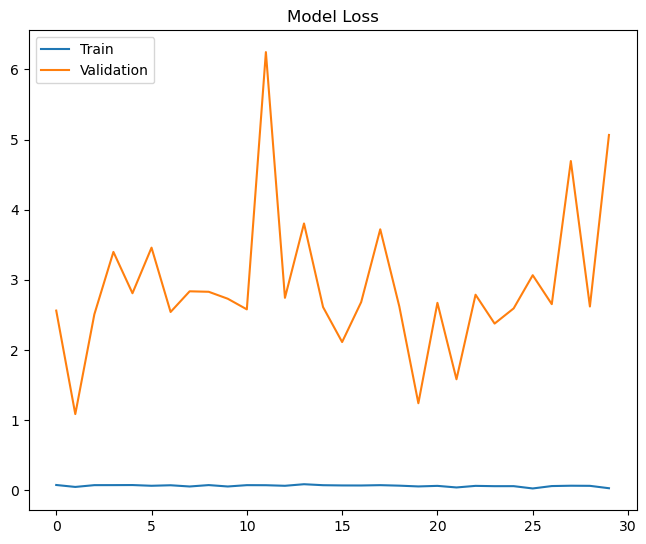

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

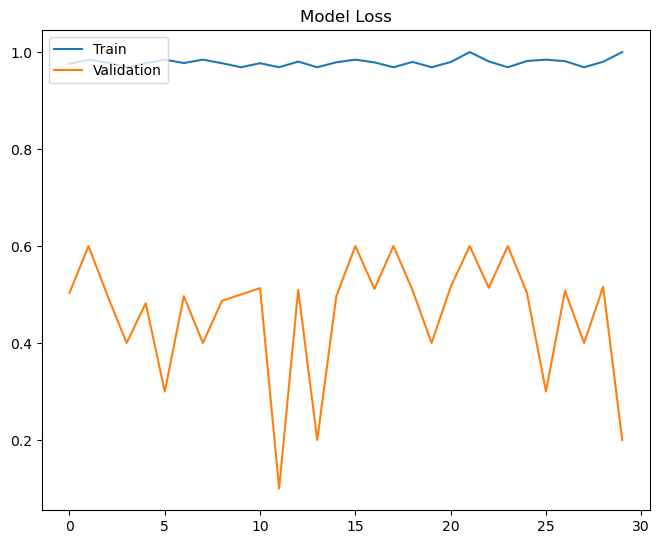

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

# SAVING MODEL

In [36]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)